In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from forex_python.converter import CurrencyRates

In [2]:
data = pd.read_csv('ADS.DE.csv', parse_dates=[0])

In [3]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-03-02,291.600006,293.200012,288.600006,290.200012,287.161804,427096
1,2021-03-03,290.000000,293.100006,286.600006,289.500000,286.469116,392201
2,2021-03-04,289.600006,289.600006,279.200012,279.200012,276.276947,617587
3,2021-03-05,278.100006,280.500000,271.500000,271.500000,268.657562,805911
4,2021-03-08,273.100006,282.000000,271.700012,280.200012,277.266479,702457
...,...,...,...,...,...,...,...
252,2022-02-24,202.149994,214.600006,200.550003,210.149994,210.149994,1532054
253,2022-02-25,213.149994,214.350006,208.449997,213.850006,213.850006,1291124
254,2022-02-28,209.250000,212.600006,206.500000,212.050003,212.050003,1326889
255,2022-03-01,212.350006,214.800003,204.050003,204.350006,204.350006,1194002


In [4]:
c = CurrencyRates()
data['exchange_rate'] = data.apply(lambda x: c.get_rate('EUR', 'USD', x.Date), axis=1)

In [5]:
data['Open_USD'] = data.apply(lambda x: x.Open*x.exchange_rate, axis=1)
data['Close_USD'] = data.apply(lambda x: x.Close*x.exchange_rate, axis=1)
data['CloseAdj_USD'] = data.apply(lambda x: x['Adj Close']*x.exchange_rate, axis=1)

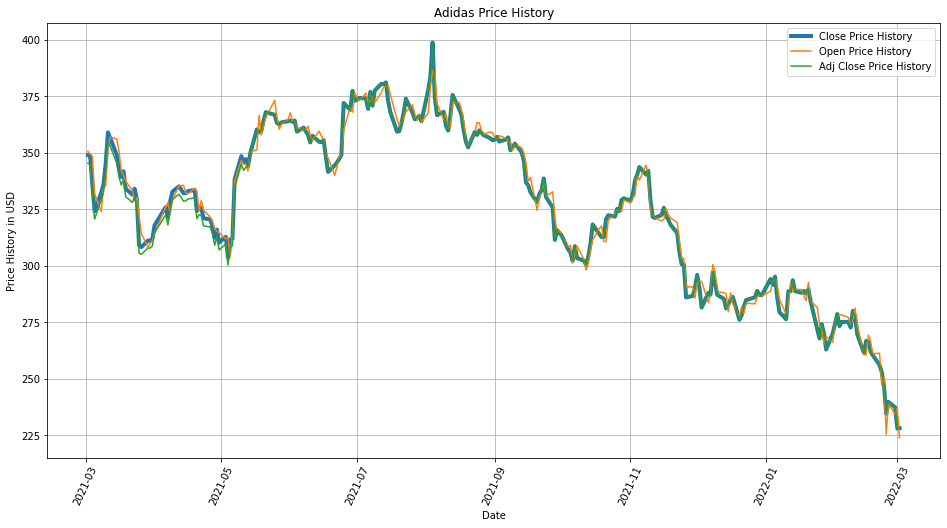

In [7]:
plt.figure(figsize=(16,8))
plt.plot(data['Date'], data['Close_USD'], label='Close Price History', linewidth=4)
plt.plot(data['Date'], data['Open_USD'], label='Open Price History')
plt.plot(data['Date'] ,data['CloseAdj_USD'], label='Adj Close Price History')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price History in USD')
plt.legend()
plt.xticks(rotation=65)
plt.title('Adidas Price History')
plt.show()

In [8]:
data.index = data['Date']
data.drop('Date', axis=1, inplace=True)

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
price = data[['Close']]

In [13]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/var/folders/tl/jg9ncc9x4vnfwb17tjw2ms480000gn/T/ipykernel_4498/2141647733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [14]:
price

,Close
Date,
2021-03-02,0.301744
2021-03-03,0.291130
2021-03-04,0.134951
2021-03-05,0.018196
2021-03-08,0.150114
...,...
2022-02-24,-0.912055
2022-02-25,-0.855951
2022-02-28,-0.883245


In [63]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [64]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
# y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
# y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [65]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [66]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [67]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [68]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
# lstm = []
gru = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))


Epoch  0 MSE:  0.23671714961528778
Epoch  1 MSE:  0.09470953047275543
Epoch  2 MSE:  0.10301476716995239
Epoch  3 MSE:  0.09245277941226959
Epoch  4 MSE:  0.062485694885253906
Epoch  5 MSE:  0.04803042486310005
Epoch  6 MSE:  0.044823646545410156
Epoch  7 MSE:  0.03943393751978874
Epoch  8 MSE:  0.025597311556339264
Epoch  9 MSE:  0.01377609372138977
Epoch  10 MSE:  0.025361500680446625
Epoch  11 MSE:  0.025815516710281372
Epoch  12 MSE:  0.015187143348157406
Epoch  13 MSE:  0.0141924899071455
Epoch  14 MSE:  0.016261618584394455
Epoch  15 MSE:  0.015304210595786572
Epoch  16 MSE:  0.012544820085167885
Epoch  17 MSE:  0.010720792226493359
Epoch  18 MSE:  0.011094578541815281
Epoch  19 MSE:  0.012587493285536766
Epoch  20 MSE:  0.012895612977445126
Epoch  21 MSE:  0.011123946867883205
Epoch  22 MSE:  0.008690486662089825
Epoch  23 MSE:  0.007437767460942268
Epoch  24 MSE:  0.007756081409752369
Epoch  25 MSE:  0.008573341183364391
Epoch  26 MSE:  0.00868174433708191
Epoch  27 MSE:  0.007

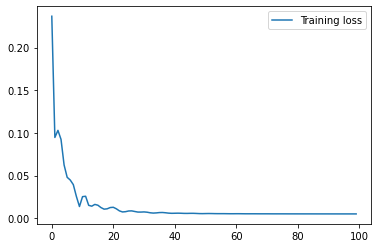

In [69]:
plt.plot(hist, label='Training loss')
plt.legend()
plt.show()

In [70]:
y_test_pred = model(x_test)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train_gru = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_gru = scaler.inverse_transform(y_test_gru.detach().numpy())



In [73]:
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train_gru[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test_gru[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.72 RMSE
Test Score: 5.84 RMSE


In [76]:
import seaborn as sns

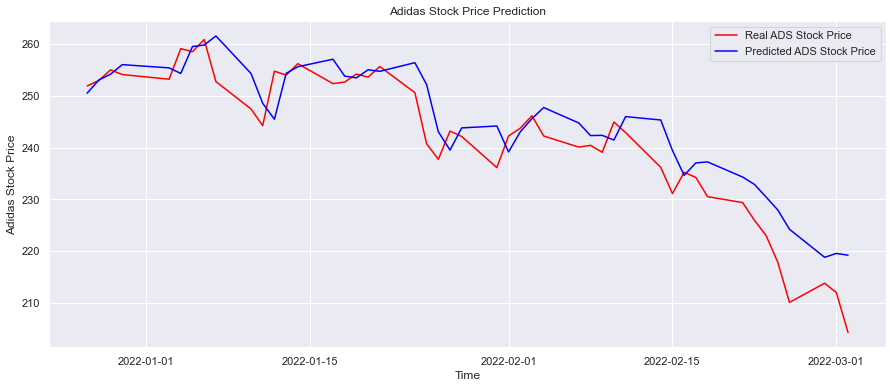

In [81]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
sns.set_theme()
sns.set_style("darkgrid")
axes.plot(data[len(data)-len(y_test_gru):].index, y_test_gru, color = 'red', label = 'Real ADS Stock Price')
axes.plot(data[len(data)-len(y_test_gru):].index, y_test_pred, color = 'blue', label = 'Predicted ADS Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Adidas Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Adidas Stock Price')
plt.legend()
plt.savefig('ads_pred.png')
plt.show()